lyric_indexs.shape (50872, 1)
durations.shape (50872, 1, 1)
notenums.shahpe (50872, 1, 1)
y.shape (50872, 128, 5)
Epoch 1/20


2025-01-04 09:24:50.927520: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 104184320 exceeds 10% of free system memory.


1272/1272 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - loss: 0.0792 - mae: 0.1030 - val_loss: 8.4085e-04 - val_mae: 0.0042
Epoch 2/20
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - loss: 8.1664e-04 - mae: 0.0041 - val_loss: 8.4051e-04 - val_mae: 0.0035
Epoch 3/20
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - loss: 7.5433e-04 - mae: 0.0037 - val_loss: 8.7784e-04 - val_mae: 0.0055
Epoch 4/20
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - loss: 7.9241e-04 - mae: 0.0037 - val_loss: 8.1834e-04 - val_mae: 0.0029
Epoch 5/20
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 7.1892e-04 - mae: 0.0046 - val_loss: 2.9554e-04 - val_mae: 0.0022
Epoch 6/20
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 3.1102e-04 - mae: 0.0037 - val_loss: 1.8746e-04 - val_mae: 0.0027
Epoch 7/20
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - loss: 2.4133e-04 - mae: 0.0032 - val_loss: 1.7248e-04 - val_mae: 0.0019
Epoch 8/20
1272/1272 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - loss: 2.2377e-04 - mae: 0.0027 - val_loss: 1.27

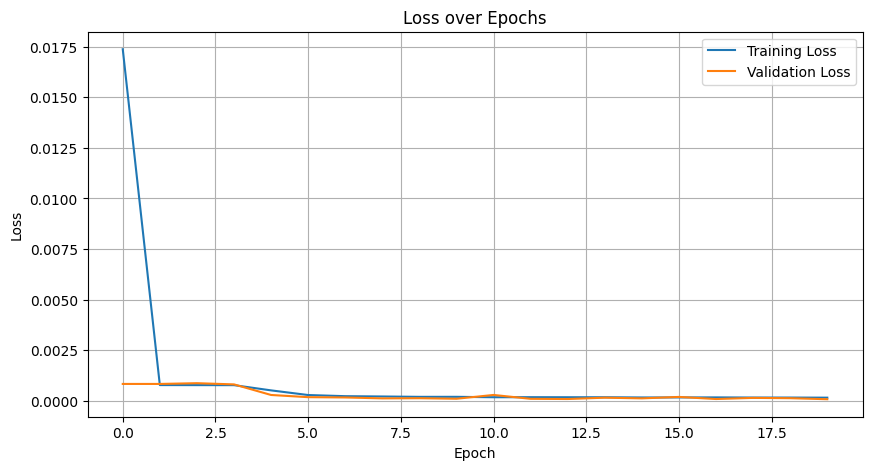

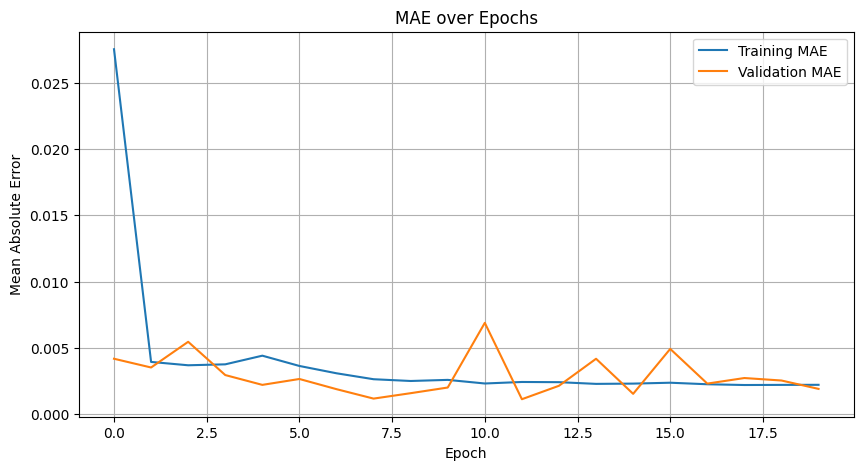

done!


In [4]:
from file_encoder import FileEncoder
from data_manager import DataManager, DataLoader
from audio_utils import N_MELS
import numpy as np
import sys
import tensorflow as tf
from tensorflow.keras import layers, models, Model
import matplotlib.pyplot as plt


TARGET_DIR = "../thirdparty/「波音リツ」歌声データベースVer2/DATABASE"
OUTPUT_DIR = "../master/ust/json"

MAX_PITCH = 100
MIN_PITCH = 0
PITCH_FEATURES = 1 # MIDI番号を0 ~ 100のスカラー
LYRIC_FEATURES = 1 # 歌詞をインデックスしたのでスカラー
DURATION_FEATURES = 1 # msの長さを正規化したのでスカラー
NOTE_CHUK_INDEX_FEATURES = 1 # 何番目の分割化を正規化したのでスカラー

LYRIC_INDEX_MAX_DIM = 256 # インデックス化した歌詞の最大インデックス(237だったので若干多めに確保)
LYRIC_DIM = 64 # インデックス化した歌詞を埋め込みした後の次元
DURATION_DIM = 1 # 正規化した長さのミリ秒（0ミリ秒 ~ 10000ミリ秒（10秒）)

# TODO: N分割したいが今後考える（ビブラートなどを考慮するにはノートを更に分割したい）
NOTE_CHUNK = 1 # 1ノートに対して1分割する


def build_model():
    pitch_input = layers.Input(shape=(NOTE_CHUNK,PITCH_FEATURES), name="pitch_input")
    lyric_input = layers.Input(shape=(NOTE_CHUNK,), name="lyric_input")
    duration_input = layers.Input(shape=(NOTE_CHUNK,DURATION_FEATURES), name="duration_input")
    # note_chunk_index_input = layers.Input(shape=(NOTE_CHUNK,NOTE_CHUK_INDEX_FEATURES), name="note_chunk_index_input") # 何番目に分割したのか保持
    
    # 歌詞を埋め込み
    lyric_embedding = layers.Embedding(output_dim=LYRIC_DIM, input_dim=LYRIC_INDEX_MAX_DIM, name="lyric_embedding")(lyric_input) # 埋め込み
    
    # 時系列
    lstm_pitch = layers.LSTM(units=64, return_sequences=True)(pitch_input)
    lstm_duration = layers.LSTM(units=64, return_sequences=True)(duration_input)
    lstm_lyric_embedding = layers.LSTM(units=64, return_sequences=True)(lyric_embedding)
    # lstm_note_chunk_index = layers.LSTM(units=64, return_sequences=True)(note_chunk_index_input)
    
    
    merged = layers.Concatenate(axis=-1, name="merged_features")(
        [lstm_pitch, lstm_lyric_embedding, lstm_duration]
        # [lstm_pitch, lstm_lyric_embedding, lstm_duration, lstm_note_chunk_index]
    )
    
    # 最終的な時系列処理
    final_lstm = layers.LSTM(128, return_sequences=True, name="final_lstm")(merged)
    
    # 出力層（例: メルスペクトログラムへの回帰）
    output = layers.TimeDistributed(layers.Dense(5, activation="tanh"), name="output")(final_lstm)
    
    # モデル定義
    model = Model(inputs=[pitch_input, lyric_input, duration_input], outputs=output)
    return model


# モデルの学習
def train_model():
    # モデル構築
    model = build_model()

    # モデルコンパイル
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])

    inputs = []

    is_from_storage = True
    
    manager = None
    if is_from_storage:
        lyric_indexs, durations, notenums, y, _ = DataLoader.load()
        inputs = [notenums, lyric_indexs, durations]
    else:
        lyric_indexs, durations, notenums, y = encoder.encode()
        inputs = [notenums, lyric_indexs, durations]
        manager = DataManager(lyric_indexs=lyric_indexs, duration_indexs=durations, notenum_indexs=notenumsm, y=y, model=model)
        manager.save()
        
    print("lyric_indexs.shape",  lyric_indexs.shape)
    print("durations.shape", durations.shape)
    print("notenums.shahpe", notenums.shape)
    print("y.shape", y.shape)

    # モデルの学習
    history = model.fit(
        inputs, # 入力データ
        y,  # ターゲットデータ
        batch_size=32,
        epochs=20,
        validation_split=0.2
    )

    return history

def plot_history(history):
    # 損失を描画
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()
    
    # 精度 (MAE) を描画
    if 'mae' in history.history:
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['mae'], label='Training MAE')
        if 'val_mae' in history.history:
            plt.plot(history.history['val_mae'], label='Validation MAE')
        plt.title('MAE over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Mean Absolute Error')
        plt.legend()
        plt.grid()
        plt.show()

# 実行
if __name__ == "__main__":
    history = train_model()
    plot_history(history)
    print("done!")